<a href="https://colab.research.google.com/github/PSLeon24/PyTorch_Tutorial/blob/main/ViT%20from%20Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Defining the task

In [3]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [4]:
from einops import rearrange

def patchify(images, n_patches):
  n, c, h, w = images.shape

  assert h == w, "image must be square"

  patches = rearrange(images, 'n c (h p1) (w p2) -> n (p1 p2 c) (h w)', p1=n_patches, p2=n_patches)
  # N x C
  return patches

def get_positional_embeddings(sequence_length, d):
  result = torch.ones(sequence_length, d)
  for i in range(sequence_length):
      for j in range(d):
          result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
  return result

class MyViT(nn.Module):
  def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.n_blocks = n_blocks
    self.n_heads = n_heads
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classification token
    self.cls_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_d, out_d),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
    tokens = self.linear_mapper(patches)

    # Adding classification token to the tokens
    tokens = torch.cat((self.cls_token.expand(n, 1, -1), tokens), dim=1)

    # Adding positional embedding
    out = tokens + self.positional_embeddings.repeat(n, 1, 1)

    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]

    return self.mlp(out) # Map to output dimension, output category distributionv

In [5]:
class MHSA(nn.Module):
  def __init__(self, d, n_heads=2):
    super(MHSA, self).__init__()
    self.d = d
    self.n_heads = n_heads

    assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

    d_head = int(d / n_heads)
    self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
    self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
    self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])

    self.d_head = d_head
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, sequences):
    result = []
    for sequence in sequences:
      seq_result = []
      for head in range(self.n_heads):
        q_mapping = self.q_mappings[head]
        k_mapping = self.k_mappings[head]
        v_mapping = self.v_mappings[head]

        seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
        q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

        attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
        seq_result.append(attention @ v)
      result.append(torch.hstack(seq_result))
    return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [6]:
class ViTBlock(nn.Module):
  def __init__(self, hidden_d, n_heads, mlp_ratio=4):
    super(ViTBlock, self).__init__()
    self.hidden_d = hidden_d
    self.n_heads = n_heads

    self.norm1 = nn.LayerNorm(hidden_d)
    self.mhsa = MHSA(hidden_d, n_heads)
    self.norm2 = nn.LayerNorm(hidden_d)
    self.mlp = nn.Sequential(
      nn.Linear(hidden_d, mlp_ratio * hidden_d),
      nn.GELU(),
      nn.Linear(mlp_ratio * hidden_d, hidden_d)
    )

  def forward(self, x):
    out = x + self.mhsa(self.norm1(x))
    return out

In [7]:
if __name__ == '__main__':
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"{device} is available")
  model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)

  model = ViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8) # Dummy images
  print(model(x).shape)

cpu is available
torch.Size([7, 50, 8])


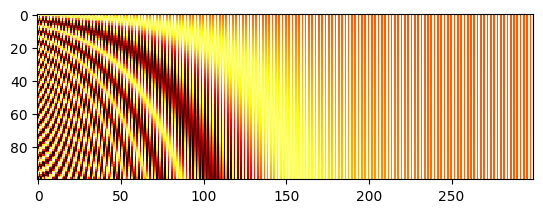

In [8]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [9]:
def main():
  # Loading data
  transform = ToTensor()

  train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
  test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

  train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"{device} is available")

  model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10)
  model.to(device)
  num_epoch = 5
  lr = 1e-4

  # Training loop
  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.00001)
  criterion = CrossEntropyLoss()

  loss_history = {"train_loss": [], "test_loss": []}

  for epoch in trange(num_epoch, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = criterion(y_hat, y)

      train_loss += loss.detach().item() / len(train_loader)
      loss_history["train_loss"].append(train_loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epoch}, train loss: {train_loss:.2f}")

  # Test loop
  with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
      x, y = batch
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = criterion(y_hat, y)

      test_loss += loss.detach().item() / len(test_loader)
      loss_history["test_loss"].append(test_loss)

      correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
      total += len(x)

    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

In [10]:
if __name__ == "__main__":
  main()

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.06MB/s]


cpu is available


Training:  20%|██        | 1/5 [02:33<10:14, 153.66s/it]

Epoch 1/5, train loss: 2.30



Training:  40%|████      | 2/5 [05:07<07:41, 153.68s/it]

Epoch 2/5, train loss: 2.20



Training:  60%|██████    | 3/5 [07:44<05:10, 155.22s/it]

Epoch 3/5, train loss: 2.08



Training:  80%|████████  | 4/5 [10:21<02:36, 156.02s/it]

Epoch 4/5, train loss: 1.99



Training: 100%|██████████| 5/5 [13:03<00:00, 156.69s/it]


Epoch 5/5, train loss: 1.93


Testing: 100%|██████████| 313/313 [00:08<00:00, 38.16it/s]

Test loss: 1.91
Test accuracy: 57.67%
